In [1]:
import os.path as path
import os
import pandas as pd
import numpy as np
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import activations, regularizers, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.models import load_model
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from keras.utils import plot_model
import matplotlib.pyplot as plt



Using TensorFlow backend.
/home/z1l3/.conda/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/z1l3/.conda/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/z1l3/.conda/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/z1l3/.conda/envs/my_env/lib/p

In [2]:
K.set_learning_phase(0)
MODEL_NAME = 'emotion_convnet'
img_rows, img_cols = 48, 48
count_features, count_labels = 64, 7
batch_size = 63
epochs = 99

In [3]:
def load_dataset():
    data_set = pd.read_csv('fer2013.csv')
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    for each, item in data_set.iterrows():
        instance = item['pixels'].split(" ")
        try:
            if item['Usage'] == 'PublicTest':
                x_test.append(np.array(instance, 'float32'))
                y_test.append(item['emotion'])
            elif item['Usage'] == 'Training':
                x_train.append(np.array(instance, 'float32'))
                y_train.append(item['emotion'])
        except:
            print('No instance found')
    return x_train, y_train, x_test, y_test

In [ ]:
# data_set.tail()

In [4]:
def prepare_data_set():
    x_train, y_train, x_test, y_test = load_dataset()
    x_train = np.array(x_train, 'float32')
    x_train -= np.mean(x_train, axis=0)
    x_train /= np.std(x_train, axis=0)
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)

    x_test = np.array(x_test, 'float32')
    x_test -= np.mean(x_test, axis=0)
    x_test /= np.std(x_test, axis=0)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

    y_train = np.array(y_train, 'float32')
    y_train = np_utils.to_categorical(y_train, count_labels)

    y_test = np.array(y_test, 'float32')
    y_test = np_utils.to_categorical(y_test, count_labels)
    return x_train, y_train, x_test, y_test

In [14]:
def build_model():
    input_shape = [img_rows, img_cols, 1]
    activation = 'relu'
    kernel_size = (3, 3)
    pool_size = (2, 2)
    strides = (2, 2)
    kernel_regularizer = regularizers.l2(0.0001)

    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation=activation, input_shape=input_shape))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation=activation, kernel_regularizer=kernel_regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation=activation, kernel_regularizer=kernel_regularizer))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(Dropout(0.5))

    model.add(
        Conv2D(filters=128, kernel_size=kernel_size, activation=activation, kernel_regularizer=kernel_regularizer))
    model.add(
        Conv2D(filters=128, kernel_size=kernel_size, activation=activation, kernel_regularizer=kernel_regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(Flatten())
    model.add(Dense(1024, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation=activation))
    model.add(Dropout(0.2))

    model.add(Dense(count_labels, activation='softmax'))
    return model

In [6]:
def train_model(my_model, x_train, y_train, x_test, y_test):
    my_model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    history = my_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                 verbose=1, validation_data=(x_test, y_test), shuffle=True)
    return history

In [8]:
def model_summary():
    print(model.summary())
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
if __name__ == '__main__':
    x_train, y_train, x_test, y_test = prepare_data_set()
    model = build_model()
    model_summary()
    history = train_model(model, x_train, y_train, x_test, y_test)
    print(history.history.keys())
    model.save("all_keras_model.h5")
    print('model_saved')
    
    
    




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_______

Epoch 30/99
28709/28709 [==============================] - 244s 8ms/step - loss: 0.1260 - acc: 0.9598 - val_loss: 3.1411 - val_acc: 0.5550
Epoch 31/99
28709/28709 [==============================] - 244s 8ms/step - loss: 0.1095 - acc: 0.9644 - val_loss: 3.0699 - val_acc: 0.5559
Epoch 32/99
28709/28709 [==============================] - 244s 8ms/step - loss: 0.1130 - acc: 0.9626 - val_loss: 3.1730 - val_acc: 0.5550
Epoch 33/99
28709/28709 [==============================] - 244s 8ms/step - loss: 0.1094 - acc: 0.9634 - val_loss: 3.0795 - val_acc: 0.5598
Epoch 34/99
28709/28709 [==============================] - 244s 8ms/step - loss: 0.0990 - acc: 0.9681 - val_loss: 3.4233 - val_acc: 0.5667
Epoch 35/99
28709/28709 [==============================] - 244s 8ms/step - loss: 0.1154 - acc: 0.9618 - val_loss: 3.2987 - val_acc: 0.5497
Epoch 36/99
28709/28709 [==============================] - 243s 8ms/step - loss: 0.1151 - acc: 0.9638 - val_loss: 3.0700 - val_acc: 0.5670
Epoch 37/99
28709/28709 [==

Epoch 89/99
28709/28709 [==============================] - 242s 8ms/step - loss: 0.0913 - acc: 0.9758 - val_loss: 3.5635 - val_acc: 0.5394
Epoch 90/99
28709/28709 [==============================] - 243s 8ms/step - loss: 0.0749 - acc: 0.9784 - val_loss: 3.8735 - val_acc: 0.5511
Epoch 91/99
28709/28709 [==============================] - 243s 8ms/step - loss: 0.0992 - acc: 0.9722 - val_loss: 3.6327 - val_acc: 0.5525
Epoch 92/99
28709/28709 [==============================] - 244s 8ms/step - loss: 0.0857 - acc: 0.9754 - val_loss: 3.7013 - val_acc: 0.5637
Epoch 93/99
28709/28709 [==============================] - 251s 9ms/step - loss: 0.0760 - acc: 0.9786 - val_loss: 3.5892 - val_acc: 0.5626
Epoch 94/99
28709/28709 [==============================] - 269s 9ms/step - loss: 0.0723 - acc: 0.9781 - val_loss: 3.7639 - val_acc: 0.5637
Epoch 95/99
28709/28709 [==============================] - 261s 9ms/step - loss: 0.0824 - acc: 0.9770 - val_loss: 3.7610 - val_acc: 0.5692
Epoch 96/99
28709/28709 [==

In [10]:
def save_keras_model(model):
    os.makedirs('./keras_model', exist_ok=True)
    model_json = model.to_json()
    with open("./keras_model/model.json", "w") as json_file:
        json_file.write(model_json) # Save keras model as JSON
    model.save_weights("./keras_model/model.h5")# serialize weights to HDF5
    print("Saved model to disk")
    
    # model.save('./keras_model/keras_model.h5')

In [11]:
save_keras_model(model)


Saved model to disk


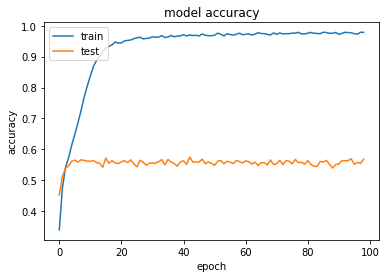

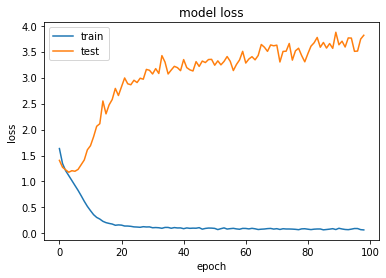

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [2]:
loaded_keras_model = load_model('./model/keras_model.h5')

NameError: name 'load_model' is not defined

In [1]:
print('These are the model inputs and outputs')
print(model.inputs)
print(model.outputs)

print('----------------------')

print(loaded_keras_model.inputs)
print(loaded_keras_model.outputs)

These are the model inputs and outputs


NameError: name 'model' is not defined

In [ ]:
MODEL_NAME = 'conda_emotion'

In [ ]:
tf.train.write_graph(K.get_session().graph_def, 'out', MODEL_NAME + '_graph.pbtxt')

In [ ]:
tf.train.Saver().save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

In [ ]:
freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, False, 'out/'
                              + MODEL_NAME + '.chkp', 'dense_3/Softmax', "save/restore_all",
                              "save/Const:0", 'out/frozen_' + MODEL_NAME + '.pb', True, "")

In [ ]:
input_graph_def = tf.GraphDef()

In [ ]:
with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
    input_graph_def.ParseFromString(f.read())

In [ ]:
output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, ['conv2d_1_input'], ['dense_3/Softmax'],
            tf.float32.as_datatype_enum)

In [ ]:
with tf.gfile.GFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
    f.write(output_graph_def.SerializeToString())

In [ ]:
print('graph saved')